In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
import networkx as nx
from scipy.stats import uniform
from PIL import Image

def draw_egde(a, b, hw=0.0, color="green"):
    # Connect points a and b with an arrow -->
    plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
    head_width=hw, length_includes_head=True, color=color
    )

def make_ring(N, K):
    # N: nodes, K: degree, avg connections per node
    # N: nodes 
    # K: neighbors, K//2 at left, K//2 at right

    # Make ring connectivity
    adj_list = []
    for ni in range(N):
        adj_list += [[]]
        for ki in range(1,K//2+1):
            adj_list[ni] += [ni-ki, ni+ki]

    adj_list = np.array([np.array(ai) for ai in adj_list])

    # Correct borders to create closed condtion
    pos = np.where(adj_list<0)
    adj_list[pos] = adj_list[pos] + N
    pos = np.where(adj_list>=N)
    adj_list[pos] = adj_list[pos] - N

    return adj_list

def plot_circular_layout(adj_list, hw=0.0, rewired_arcs=None):
    t = np.linspace(0, 2*np.pi, N, endpoint=False)  # angle in radians
    # Convert from polar to cartesian 
    x = np.cos(t)
    y = np.sin(t)

    plt.figure(figsize=(8,8))
    plt.plot(x, y, '.', ms=30)
    #a = plt.xlim(-0.1, 2.1)
    #a = plt.ylim(-0.1, 2.1)
    a = plt.axis('off')
    for i in range(N):
        plt.text(x[i]-0.015, y[i]-0.015, i, weight='bold', c='w')
    # a: node of origin, b: destination node. a --> b
    e = [draw_egde([x[a], y[a]], [x[b], y[b]], hw) for a in adj_list for b in adj_list[a]]

    if rewired_arcs is not None:
        e = [draw_egde([x[a], y[a]], [x[b], y[b]], hw, 'red') 
            for a in rewired_arcs for b in rewired_arcs[a]]

def rewire_ring(C, omega):
    # C: adjacecy list, omega: K_r / K, fraction of random shortcuts
    # loop over nodes
    all_nodes = set(range(len(C)))
    for i, ci in enumerate(C):
        # loop over neighborhood
        for j, cj in enumerate(ci):
            # rewire if U(0,1) < omega
            if np.random.random() < omega:
                available_nodes = list(all_nodes - (set([i] + list(ci)) - set([cj])))
                C[i, j] = np.random.choice(available_nodes)

def make_random(N, K):
    # erdos renyi model
    C = []
    for i in range(N):
        C += np.where(np.insert(bernoulli.rvs(K/N, size=(N-1)), i, 0))
    return np.array(C, dtype='object')

In [ ]:
P = 1
N = 10
a = 0.5  # pattern activity
xi = bernoulli.rvs(p=a, size=(P,N))*2-1
xi, xi.mean(), xi.var()


(array([[ 1,  1,  1,  1, -1, -1,  1, -1,  1,  1]]), 0.4, 0.8399999999999999)

In [ ]:
a = 0.1  # pattern activity
xi = bernoulli.rvs(p=a, size=(P,N))
xi, xi.mean()

(array([[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]]), 0.2)

In [ ]:
normalized_xi = (xi - xi.mean()) / xi.std()
normalized_xi.mean(), normalized_xi.std()

(-1.1102230246251566e-17, 0.9999999999999999)

### ANN

0. Generate/read/load a set of patterns P
1. Generate network structure, connectivity C, and W=0.
2. **Learning stage:** Learn the pattern set (Hebbian learning)
    - Update Wij += Wij. Commulative.
3. **Retrieval stage**
  3.1 Start network in a learned pattern o close to it. 
  - Noise
  - Fragment
  3.2 Evolve the network to a final state
  3.3 Check the quality of retrieval

### * Biased case
- Normalize the patterns
- Dynamic **retrieval neural threshold** to keep the **activity** of the network
  - $\Theta(h - \theta)$, $h$ is the normalized neural input, $\theta$ is the **neural threshold**.

(0.1044921875, 0.10009765625, (10, 16384))

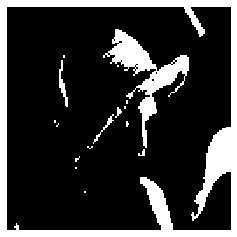

In [ ]:
from matplotlib import colors

cmap = colors.ListedColormap(['black', 'white'])

N = 128*128  # size of the pattern gives the size of the neuron
K = 100  # mean connectivity, number of stored patterns depends on the connection density
omega = 0
#C = make_ring(N, K)  # connectivity matrix
C = make_random(N, K)
#rewire_ring(C, omega)  # rewire SW

W = np.array([np.zeros(len(ci)) for ci in C], dtype='object')  # start W as 0 matrix

# Generate a set of random patterns of activity a
a = 0.1  # pattern/network activity (unbiased) a \in (0,1)
P = 9
X = bernoulli.rvs(p=a, size=(P,N))

img = Image.open('../lenna.png')
img = img.resize((128,128), Image.ANTIALIAS)
imggs = img.convert('L')
th_value = 185
imgbw = np.asarray(imggs)
imgbw = (imgbw > th_value)*1
lenna = imgbw.reshape(1, 128*128)
X = np.concatenate((X, lenna)) # add pattern image to pattern set X
plt.matshow(lenna.reshape(128,128), cmap="gray"); plt.axis('off')
lenna.mean(), X.mean(), np.shape(X)

In [ ]:
# Learning, update weights
# for each pattern

# normalized data set
normalized_X = np.array([(xi - xi.mean()) / xi.std() for xi in X])

for xi in normalized_X:
    # for each node i in the network
    # update weights with its neighborhood
    for i in range(N):
        # xi[C[i]] state of the neighborhood
        # xi[i] state od node i
        W[i] += xi[C[i]] * xi[i]

In [ ]:
def normalize_vector(vector):
    # normalize neural input h
    return (vector - vector.mean()) / vector.std()

def act_threshold(neighbors, th):
    threshold = th
    if neighbors.mean() > 0.5:
        threshold = -th
    return threshold

In [ ]:
M = []
time = 100
th = 1.3333

# Non normalized data set X
for xi in X:
    xit = np.copy(xi)
    m = [(normalize_vector(xi) * normalize_vector(xit)).mean()]
    
    for ti in range(time):
        xit = np.array([(normalize_vector(xit[C[ni]]) * W[ni]).mean() - act_threshold(xit[C[ni]], th) >= 0 
                if xit[C[ni]].var() else xit[ni] for ni in range(N)
            ])
        m += [(normalize_vector(xi) * normalize_vector(xit)).mean()]
        if m[-1] == m[-2]:
            break
    
    M += [m[-1]]
M

[0.9973063159629009,
 0.9973978453835552,
 0.9966294380126637,
 0.9937500950954479,
 0.9986494573683067,
 0.997893643729607,
 0.9952946421296416,
 0.9989727209116739,
 0.9968879899183098,
 0.9964184623528951]

(array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (1, 16384))

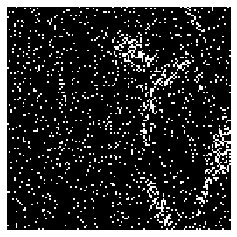

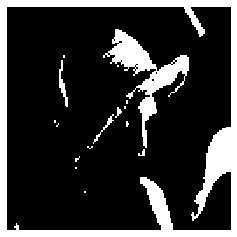

In [ ]:
noise_level = 0.7

noisy_lenna = lenna.copy()

a = 0.1  # pattern activity

for i in range(np.shape(noisy_lenna)[1]):
    if np.random.random() < noise_level:
        noisy_lenna[0, i] = bernoulli.rvs(a)

plt.matshow(noisy_lenna.reshape((128,128)), cmap=cmap)
a = plt.axis('off')

x = X[-1] 
plt.matshow(x.reshape((128,128)), cmap=cmap)
a = plt.axis('off')

noisy_lenna.reshape((128,128)), np.shape(noisy_lenna)

Text(0.5, 0, 'quality of retrieval (m)')

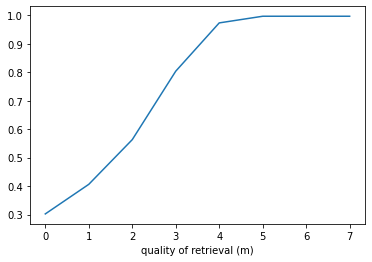

In [ ]:
xi = X[-1]
xit = noisy_lenna.flatten()  # initial state (noisy lenna)
m = [(normalize_vector(xi) * normalize_vector(xit)).mean()]

for ti in range(time):
    xit = np.array([(normalize_vector(xit[C[ni]]) * W[ni]).mean() - act_threshold(xit[C[ni]], th) >= 0 
            if xit[C[ni]].var() else xit[ni] for ni in range(N)
        ])
    m += [(normalize_vector(xi) * normalize_vector(xit)).mean()]
    if m[-1] == m[-2]:
        break
plt.plot(m)  # plot temporal evolution of the overlap m, quality of retrieval
plt.xlabel('time steps')
plt.xlabel('quality of retrieval (m)')

0.9964184623528951

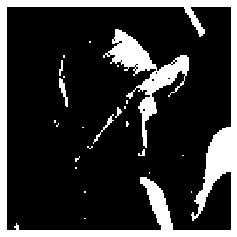

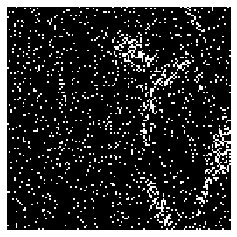

In [ ]:
plt.matshow(xit.reshape((128,128)), cmap=cmap)
a = plt.axis('off')

plt.matshow(noisy_lenna.reshape((128,128)), cmap=cmap)
a = plt.axis('off')

m[-1]

0.021484375
0.07281494140625
0.10467529296875
0.10479736328125


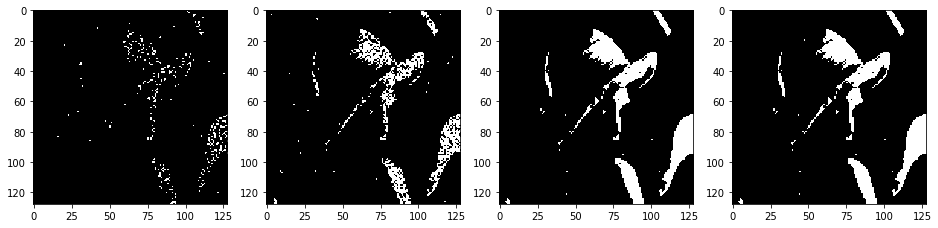

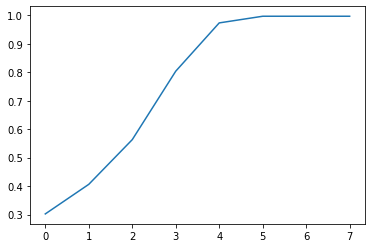

0.9964184623528951

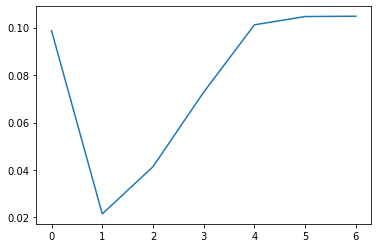

In [ ]:
x = X[-1]  # Learned Lenna is in X, last pattern

xt = np.copy(noisy_lenna.flatten())  # init network in noisy lenna
        
m = [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # initial overlap

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,32))
ploti = 0

a_net = []

for ti in range(100):
    # network update for t=100
    a_net += [np.mean(xt)]
    # update each neuron xt[nxi]
    xt = np.array([(np.mean(normalize_vector(xt[C[nxi]])*W[nxi]) 
                    - act_threshold(xt[C[nxi]], th) >= 0)  # TH(local_field, threshod)
                   if np.var(xt[C[nxi]])  # if variance is not zero
                   else xt[nxi]  # state does not change otherwise
                   for nxi in range(N)])
    xt = xt.astype('int')
    m += [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # test overlap x and xt (net state)
    if not (ti % 2):
        print(np.mean(xt))
        ax[ploti].imshow(xt.reshape((128,128)), cmap=cmap)
        ploti += 1
    if m[-1] == m[-2]:
        break
plt.show()
plt.plot(m)
plt.show()
plt.plot(a_net)
m[-1]

### Threshold th

$\theta(a) = \frac{(1 - 2*a)} {2 \sqrt {a * (1 - a)}}$

In [ ]:
 a = 0.1
 (1 - 2*a) / (2 * np.sqrt(a * (1-a)))

1.3333333333333333

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cce3455d-da08-4c10-a6fe-39f2a30c6a51' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>